In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-02-07 10:04:18.451372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 10:04:18.651459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738902858.739021    4432 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738902858.763451    4432 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 10:04:18.954179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [3]:
lagdata = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagdata.columns = [f'lag_{i}' for i in range(5, -1, -1)]
X = lagdata.iloc[:, 1:].values  
y = lagdata.iloc[:, 0].values

NameError: name 'diff_close_series' is not defined

In [9]:
# diffcloseseires = df['Close'].diff().dropna()

In [18]:
scalerx = StandardScaler()
xscaled = scalerx.fit_transform(X)

In [19]:
X_reshaped = xscaled.reshape((xscaled.shape[0], xscaled.shape[1], 1))

In [20]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/ryu/code/python/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.fit(X_reshaped, y, epochs=200, batch_size=8, verbose=0)

In [22]:
ypredlist = []

In [23]:
for i in range(len(xscaled)):
    X_input = xscaled[i].reshape((1, X_reshaped.shape[1], 1))
    
    y_pred_raw = model.predict(X_input, verbose=0)
    ypredlist.append(y_pred_raw[0][0]) 

In [24]:
y_pred = np.array(ypredlist)

scaler_y = StandardScaler()
y_scaled_actual = scaler_y.fit_transform(y.reshape(-1, 1))
y_scaled_pred = scaler_y.transform(y_pred.reshape(-1, 1))

In [25]:
mse = mean_squared_error(y_scaled_actual, y_scaled_pred)
r2 = r2_score(y_scaled_actual, y_scaled_pred)

In [28]:
print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R2: {r2:.6f}")

LSTM MSE: 0.498432
LSTM R2: 0.501568


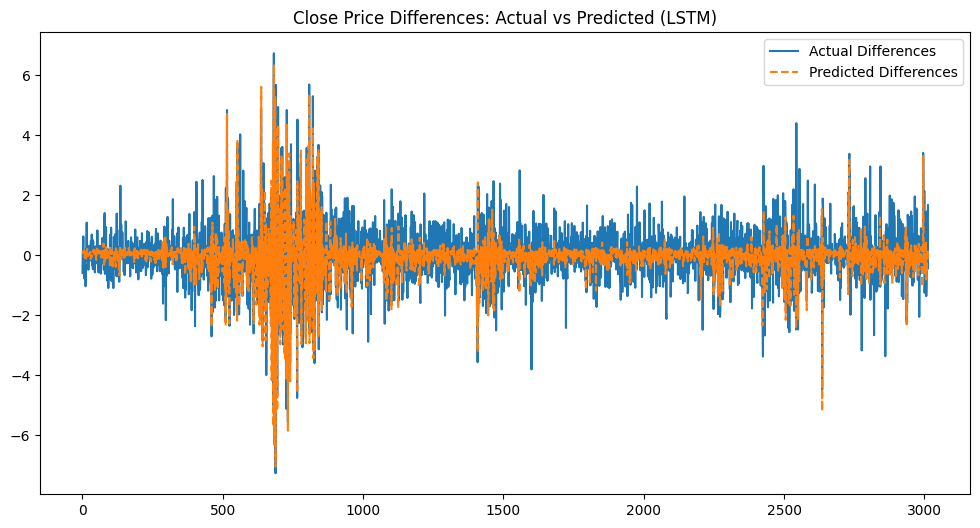

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_scaled_actual, label='actual differences')
plt.plot(y_scaled_pred, label='predicted differences', linestyle='dashed')
plt.title("close price differences: actual vs predicted (LSTM)")
plt.legend()
plt.show()